# Mejora del Modelo de Predicción de Precios - Casas Ahome

## Objetivo
Mejorar el R² (actualmente 0.84) y reducir el MAE (actualmente $791,652 MXN) del modelo Random Forest original mediante **7 estrategias** concretas:

1. **Ingeniería de Features** — Crear nuevas variables derivadas
2. **Incluir la variable Colonia** — Aprovechar la ubicación
3. **Incluir la variable Antigüedad** — Aprovechar la edad del inmueble
4. **Tratamiento de Outliers** — Limpiar datos extremos
5. **Transformación Logarítmica del Target** — Normalizar distribución de precios
6. **Hyperparameter Tuning** — Optimizar Random Forest con GridSearchCV
7. **Comparar múltiples algoritmos** — RF vs Gradient Boosting vs XGBoost vs Ridge

### Modelo base de referencia
| Métrica | Valor actual |
|---------|-------------|
| R²      | 0.84        |
| MAE     | $791,652    |
| Features| 5 (Construcción, Terreno, Recámaras, Baños, Estacionamiento) |

---
## FASE 0: Carga de datos y reproducción del modelo base

In [1]:
# ============================================================
# IMPORTACIONES GENERALES
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Intentar importar XGBoost (si no está instalado, se omite)
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
    print("✅ XGBoost disponible")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost no instalado. Para instalarlo: pip install xgboost")

print("✅ Todas las librerías cargadas correctamente")

⚠️ XGBoost no instalado. Para instalarlo: pip install xgboost
✅ Todas las librerías cargadas correctamente


In [2]:
# ============================================================
# CARGA Y LIMPIEZA DE DATOS
# ============================================================
df = pd.read_csv('ViviendasAhomeDic2025Colcode.csv')

# Convertir Precio de string a numérico
if df['Precio'].dtype == 'object':
    df['Precio'] = df['Precio'].str.replace(',', '', regex=False).astype(float)

print(f"Dataset cargado: {df.shape[0]} registros, {df.shape[1]} columnas")
print(f"\nRango de precios: ${df['Precio'].min():,.0f} — ${df['Precio'].max():,.0f} MXN")
print(f"Precio mediano: ${df['Precio'].median():,.0f} MXN")
print(f"Precio promedio: ${df['Precio'].mean():,.0f} MXN")
df.head()

Dataset cargado: 186 registros, 8 columnas

Rango de precios: $360,000 — $15,500,000 MXN
Precio mediano: $3,425,000 MXN
Precio promedio: $4,083,275 MXN


,Colonia,Construcción,Terreno,Ant,Recamaras,Baños,Estacionamiento,Precio
0,0.86,209.0,209.0,0,3,3.0,2,4850000.0
1,0.08,397.0,166.0,20,7,4.0,2,4800000.0
2,0.51,275.0,144.0,5,4,4.0,2,4380000.0
3,0.61,105.0,122.0,15,3,1.0,2,1980000.0
4,0.32,206.0,126.0,7,3,2.0,3,3300000.0


In [3]:
# ============================================================
# MODELO BASE (reproducción exacta del original)
# ============================================================
feature_cols_base = ['Construcción', 'Terreno', 'Recamaras', 'Baños', 'Estacionamiento']
X_base = df[feature_cols_base]
y_base = df['Precio']

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42
)

model_base = RandomForestRegressor(n_estimators=100, random_state=42)
model_base.fit(X_train_b, y_train_b)
y_pred_base = model_base.predict(X_test_b)

r2_base = r2_score(y_test_b, y_pred_base)
mae_base = mean_absolute_error(y_test_b, y_pred_base)

print("="*60)
print("MODELO BASE (referencia)")
print("="*60)
print(f"  Features:  {len(feature_cols_base)} → {feature_cols_base}")
print(f"  R²:        {r2_base:.4f}")
print(f"  MAE:       ${mae_base:,.2f} MXN")
print("="*60)

MODELO BASE (referencia)
  Features:  5 → ['Construcción', 'Terreno', 'Recamaras', 'Baños', 'Estacionamiento']
  R²:        0.8396
  MAE:       $791,651.92 MXN


---
## FASE 1: Análisis exploratorio avanzado
Antes de mejorar el modelo, necesitamos entender mejor los datos.

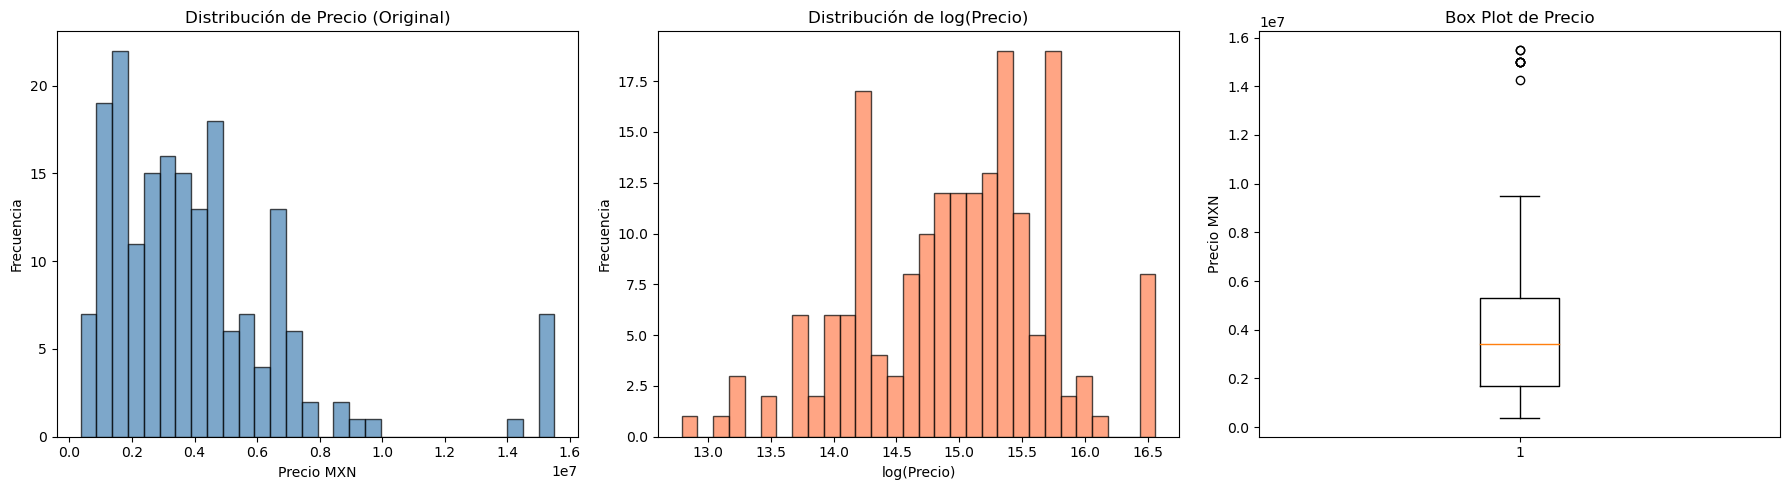


Sesgo (Skewness) del Precio: 1.917
Curtosis (Kurtosis) del Precio: 4.604
→ La distribución está SESGADA A LA DERECHA. La transformación logarítmica puede ayudar.


In [4]:
# ============================================================
# DISTRIBUCIÓN DEL PRECIO (¿está sesgada?)
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histograma de precios originales
axes[0].hist(df['Precio'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribución de Precio (Original)', fontsize=12)
axes[0].set_xlabel('Precio MXN')
axes[0].set_ylabel('Frecuencia')

# Histograma de log(Precio)
axes[1].hist(np.log1p(df['Precio']), bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribución de log(Precio)', fontsize=12)
axes[1].set_xlabel('log(Precio)')
axes[1].set_ylabel('Frecuencia')

# Box plot para detectar outliers
axes[2].boxplot(df['Precio'], vert=True)
axes[2].set_title('Box Plot de Precio', fontsize=12)
axes[2].set_ylabel('Precio MXN')

plt.tight_layout()
plt.show()

# Estadísticas de sesgo
skewness = df['Precio'].skew()
kurtosis = df['Precio'].kurtosis()
print(f"\nSesgo (Skewness) del Precio: {skewness:.3f}")
print(f"Curtosis (Kurtosis) del Precio: {kurtosis:.3f}")
if skewness > 1:
    print("→ La distribución está SESGADA A LA DERECHA. La transformación logarítmica puede ayudar.")
elif skewness > 0.5:
    print("→ La distribución tiene sesgo moderado. La transformación logarítmica podría ayudar.")
else:
    print("→ La distribución es razonablemente simétrica.")

In [5]:
# ============================================================
# DETECCIÓN DE OUTLIERS con IQR
# ============================================================
Q1 = df['Precio'].quantile(0.25)
Q3 = df['Precio'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Precio'] < lower_bound) | (df['Precio'] > upper_bound)]
print(f"Rango intercuartil (IQR): ${IQR:,.0f}")
print(f"Límite inferior: ${lower_bound:,.0f}")
print(f"Límite superior: ${upper_bound:,.0f}")
print(f"\n🔴 Outliers detectados: {len(outliers)} de {len(df)} registros ({len(outliers)/len(df)*100:.1f}%)")
if len(outliers) > 0:
    print(f"\nOutliers (precios extremos):")
    print(outliers[['Colonia', 'Construcción', 'Terreno', 'Precio']].sort_values('Precio', ascending=False).to_string())

Rango intercuartil (IQR): $3,595,000
Límite inferior: $-3,687,500
Límite superior: $10,692,500

🔴 Outliers detectados: 8 de 186 registros (4.3%)

Outliers (precios extremos):
     Colonia  Construcción  Terreno      Precio
16      0.90        467.00    960.0  15500000.0
55      0.90        467.00    960.0  15500000.0
18      0.90        691.00    763.0  15000000.0
59      0.90        691.00    763.0  15000000.0
85      0.75        648.00    900.0  15000000.0
131     0.45        648.00    900.0  15000000.0
148     0.42        467.50    960.0  15000000.0
171     0.78        573.49    470.0  14250000.0


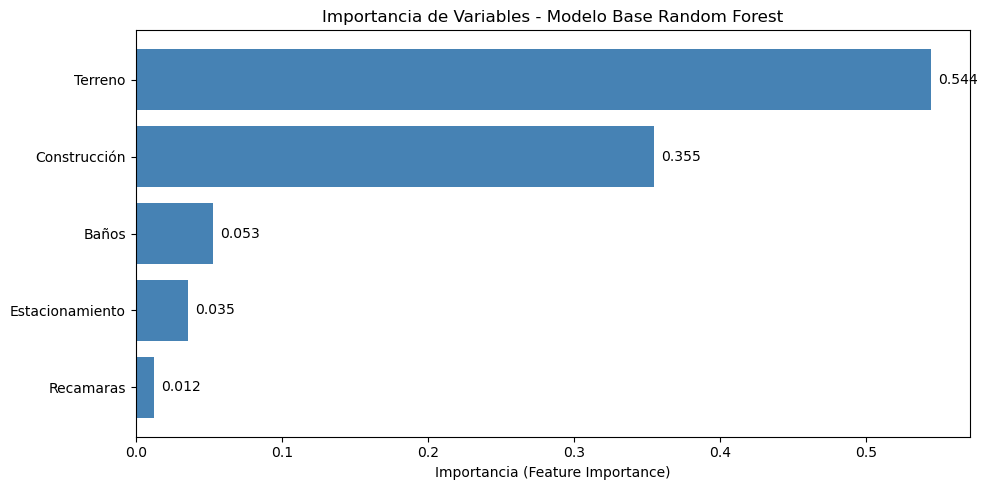

In [6]:
# ============================================================
# IMPORTANCIA DE VARIABLES DEL MODELO BASE
# ============================================================
importances = model_base.feature_importances_
feat_importance = pd.DataFrame({
    'Feature': feature_cols_base,
    'Importancia': importances
}).sort_values('Importancia', ascending=True)

plt.figure(figsize=(10, 5))
plt.barh(feat_importance['Feature'], feat_importance['Importancia'], color='steelblue')
plt.xlabel('Importancia (Feature Importance)')
plt.title('Importancia de Variables - Modelo Base Random Forest')
for i, v in enumerate(feat_importance['Importancia']):
    plt.text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=10)
plt.tight_layout()
plt.show()

---
## FASE 2: Ingeniería de Features

### ¿Por qué funciona?
Crear variables derivadas permite al modelo capturar relaciones que las variables crudas por sí solas no expresan. Por ejemplo:
- El **precio por m²** varía enormemente según la zona
- La **proporción construcción/terreno** indica densidad de aprovechamiento
- La **Antigüedad** y la **Colonia** contienen información que el modelo base ignora

In [7]:
# ============================================================
# CREAR NUEVAS FEATURES
# ============================================================
df_feat = df.copy()

# --- Feature 1: Ratio Construcción / Terreno ---
# Indica qué proporción del terreno está construida (densidad de aprovechamiento)
df_feat['Ratio_Const_Terreno'] = df_feat['Construcción'] / df_feat['Terreno']

# --- Feature 2: Superficie total útil (proxy) ---
# Combina construcción + terreno como indicador de tamaño total
df_feat['Superficie_Total'] = df_feat['Construcción'] + df_feat['Terreno']

# --- Feature 3: Amenidades totales ---
# Suma de recámaras + baños + estacionamientos como proxy de "nivel de equipamiento"
df_feat['Amenidades_Total'] = df_feat['Recamaras'] + df_feat['Baños'] + df_feat['Estacionamiento']

# --- Feature 4: Baños por recámara ---
# Proporción que indica nivel de confort/lujo
df_feat['Banos_por_Recamara'] = df_feat['Baños'] / df_feat['Recamaras'].replace(0, 1)

# --- Feature 5: Construcción al cuadrado ---
# Captura relación no lineal entre superficie y precio
df_feat['Construccion_Sq'] = df_feat['Construcción'] ** 2

# --- Feature 6: Terreno al cuadrado ---
df_feat['Terreno_Sq'] = df_feat['Terreno'] ** 2

# --- Feature 7: Interacción Construcción × Baños ---
# Propiedades grandes con muchos baños tienden a ser de mayor valor
df_feat['Construccion_x_Banos'] = df_feat['Construcción'] * df_feat['Baños']

# --- Feature 8: Antigüedad (YA EXISTE en el dataset como 'Ant') ---
# La incluimos explícitamente como feature
# También creamos una versión categórica
df_feat['Es_Nueva'] = (df_feat['Ant'] == 0).astype(int)  # 1 si es nueva, 0 si no
df_feat['Ant_Grupo'] = pd.cut(df_feat['Ant'], bins=[-1, 0, 5, 10, 20, 50], 
                               labels=[0, 1, 2, 3, 4]).astype(int)

print("✅ Nuevas features creadas:")
nuevas_cols = ['Ratio_Const_Terreno', 'Superficie_Total', 'Amenidades_Total', 
               'Banos_por_Recamara', 'Construccion_Sq', 'Terreno_Sq',
               'Construccion_x_Banos', 'Es_Nueva', 'Ant_Grupo']
for col in nuevas_cols:
    print(f"   • {col}: min={df_feat[col].min():.2f}, max={df_feat[col].max():.2f}, mean={df_feat[col].mean():.2f}")

print(f"\nTotal de columnas: {df_feat.shape[1]}")
df_feat.head()

✅ Nuevas features creadas:
   • Ratio_Const_Terreno: min=0.17, max=6.13, mean=1.11
   • Superficie_Total: min=137.00, max=1548.00, mean=465.86
   • Amenidades_Total: min=3.00, max=15.00, mean=7.56
   • Banos_por_Recamara: min=0.20, max=1.75, mean=0.80
   • Construccion_Sq: min=2209.00, max=664225.00, mean=67972.10
   • Terreno_Sq: min=3769.96, max=921600.00, mean=91723.40
   • Construccion_x_Banos: min=47.00, max=4146.00, mean=700.97
   • Es_Nueva: min=0.00, max=1.00, mean=0.09
   • Ant_Grupo: min=0.00, max=4.00, mean=2.56

Total de columnas: 17


,Colonia,Construcción,Terreno,Ant,Recamaras,Baños,Estacionamiento,Precio,Ratio_Const_Terreno,Superficie_Total,Amenidades_Total,Banos_por_Recamara,Construccion_Sq,Terreno_Sq,Construccion_x_Banos,Es_Nueva,Ant_Grupo
0,0.86,209.0,209.0,0,3,3.0,2,4850000.0,1.000000,418.0,8.0,1.000000,43681.0,43681.0,627.0,1,0
1,0.08,397.0,166.0,20,7,4.0,2,4800000.0,2.391566,563.0,13.0,0.571429,157609.0,27556.0,1588.0,0,3
2,0.51,275.0,144.0,5,4,4.0,2,4380000.0,1.909722,419.0,10.0,1.000000,75625.0,20736.0,1100.0,0,1
3,0.61,105.0,122.0,15,3,1.0,2,1980000.0,0.860656,227.0,6.0,0.333333,11025.0,14884.0,105.0,0,3
4,0.32,206.0,126.0,7,3,2.0,3,3300000.0,1.634921,332.0,8.0,0.666667,42436.0,15876.0,412.0,0,2


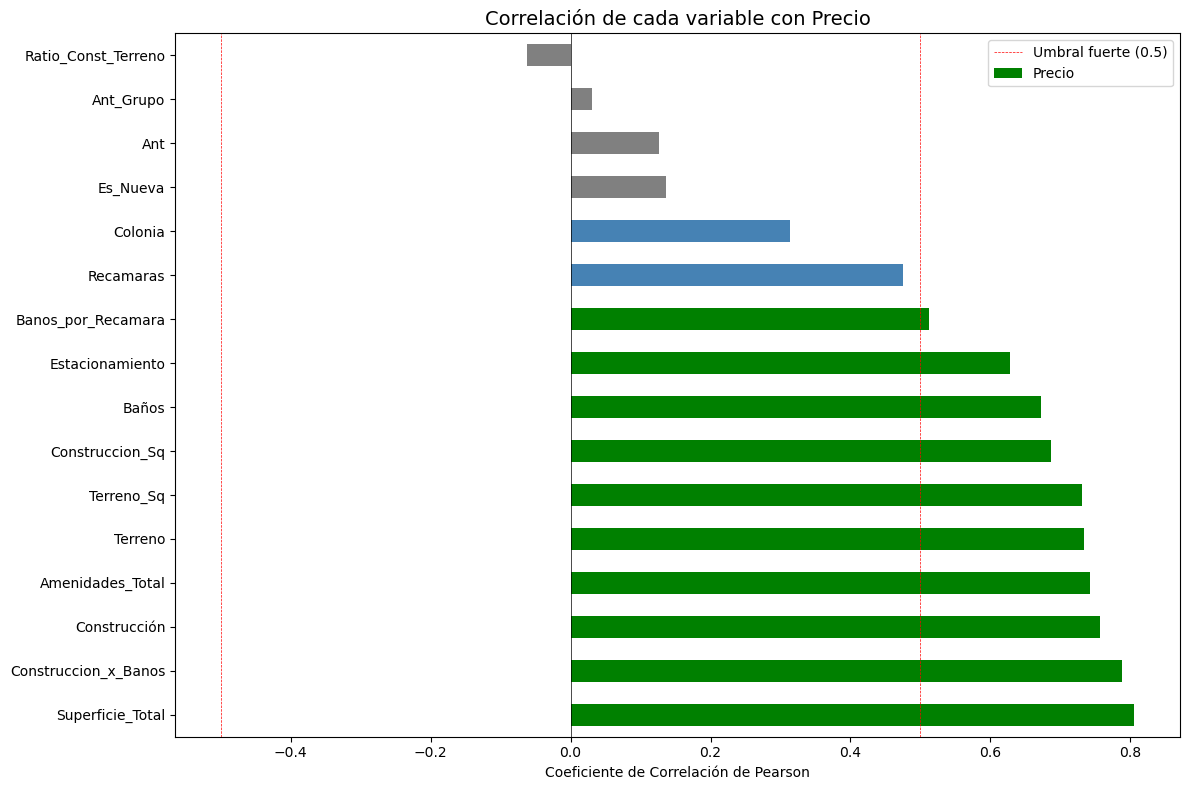


📊 Top 10 variables más correlacionadas con Precio:
   🟢 Superficie_Total: 0.8057
   🟢 Construccion_x_Banos: 0.7885
   🟢 Construcción: 0.7564
   🟢 Amenidades_Total: 0.7421
   🟢 Terreno: 0.7337
   🟢 Terreno_Sq: 0.7310
   🟢 Construccion_Sq: 0.6862
   🟢 Baños: 0.6719
   🟢 Estacionamiento: 0.6285
   🟢 Banos_por_Recamara: 0.5129


In [8]:
# ============================================================
# CORRELACIÓN DE NUEVAS FEATURES CON PRECIO
# ============================================================
all_features = feature_cols_base + ['Ant', 'Colonia'] + nuevas_cols
corr_with_price = df_feat[all_features + ['Precio']].corr()['Precio'].drop('Precio').sort_values(ascending=False)

plt.figure(figsize=(12, 8))
colors = ['green' if x > 0.5 else 'steelblue' if x > 0.3 else 'gray' for x in corr_with_price.abs()]
corr_with_price.plot(kind='barh', color=colors)
plt.title('Correlación de cada variable con Precio', fontsize=14)
plt.xlabel('Coeficiente de Correlación de Pearson')
plt.axvline(x=0, color='black', linewidth=0.5)
plt.axvline(x=0.5, color='red', linewidth=0.5, linestyle='--', label='Umbral fuerte (0.5)')
plt.axvline(x=-0.5, color='red', linewidth=0.5, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

print("\n📊 Top 10 variables más correlacionadas con Precio:")
for feat, corr_val in corr_with_price.head(10).items():
    marker = "🟢" if abs(corr_val) > 0.5 else "🔵" if abs(corr_val) > 0.3 else "⚪"
    print(f"   {marker} {feat}: {corr_val:.4f}")

---
## FASE 3: Estrategia de mejora — Modelos incrementales

Vamos a comparar **6 variantes** del modelo, agregando mejoras de forma incremental para ver cuál aporta más.

In [9]:
# ============================================================
# FUNCIÓN AUXILIAR para entrenar y evaluar modelos
# ============================================================
def evaluar_modelo(X, y, model, nombre, use_log_target=False, cv_folds=5):
    """
    Entrena, evalúa y reporta métricas de un modelo.
    Incluye validación cruzada K-Fold.
    """
    # Si se usa log del target
    if use_log_target:
        y_transformed = np.log1p(y)
    else:
        y_transformed = y
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_transformed, test_size=0.2, random_state=42
    )
    
    # Entrenar
    model.fit(X_train, y_train)
    
    # Predecir
    y_pred = model.predict(X_test)
    
    # Si se usó log, revertir
    if use_log_target:
        y_test_real = np.expm1(y_test)
        y_pred_real = np.expm1(y_pred)
    else:
        y_test_real = y_test
        y_pred_real = y_pred
    
    # Métricas
    r2 = r2_score(y_test_real, y_pred_real)
    mae = mean_absolute_error(y_test_real, y_pred_real)
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X, y_transformed, cv=cv_folds, scoring='r2')
    
    # Error relativo medio
    mape = np.mean(np.abs((y_test_real - y_pred_real) / y_test_real)) * 100
    
    resultado = {
        'Modelo': nombre,
        'R²': r2,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'CV R² (mean)': cv_scores.mean(),
        'CV R² (std)': cv_scores.std(),
        'y_test': y_test_real,
        'y_pred': y_pred_real
    }
    
    return resultado

print("✅ Función de evaluación definida")

✅ Función de evaluación definida


In [10]:
# ============================================================
# MODELO 1: BASE (5 features originales) — Ya calculado arriba
# ============================================================
resultados = []

# Modelo 1: Base original
X1 = df_feat[['Construcción', 'Terreno', 'Recamaras', 'Baños', 'Estacionamiento']]
y = df_feat['Precio']
res1 = evaluar_modelo(X1, y, RandomForestRegressor(n_estimators=100, random_state=42),
                       'M1: Base (5 features)')
resultados.append(res1)
print(f"M1 Base → R²: {res1['R²']:.4f} | MAE: ${res1['MAE']:,.0f} | CV R²: {res1['CV R² (mean)']:.4f} ± {res1['CV R² (std)']:.4f}")

M1 Base → R²: 0.8396 | MAE: $791,652 | CV R²: 0.7147 ± 0.2006


In [11]:
# ============================================================
# MODELO 2: Agregar Antigüedad + Colonia (7 features)
# ============================================================
X2 = df_feat[['Construcción', 'Terreno', 'Recamaras', 'Baños', 'Estacionamiento',
              'Ant', 'Colonia']]
res2 = evaluar_modelo(X2, y, RandomForestRegressor(n_estimators=100, random_state=42),
                       'M2: +Antigüedad +Colonia (7 feat)')
resultados.append(res2)
print(f"M2 +Ant+Col → R²: {res2['R²']:.4f} | MAE: ${res2['MAE']:,.0f} | CV R²: {res2['CV R² (mean)']:.4f} ± {res2['CV R² (std)']:.4f}")

M2 +Ant+Col → R²: 0.8589 | MAE: $801,031 | CV R²: 0.7108 ± 0.2061


In [12]:
# ============================================================
# MODELO 3: Todas las features engineered (16 features)
# ============================================================
feature_cols_full = ['Construcción', 'Terreno', 'Recamaras', 'Baños', 'Estacionamiento',
                     'Ant', 'Colonia',
                     'Ratio_Const_Terreno', 'Superficie_Total', 'Amenidades_Total',
                     'Banos_por_Recamara', 'Construccion_Sq', 'Terreno_Sq',
                     'Construccion_x_Banos', 'Es_Nueva', 'Ant_Grupo']

X3 = df_feat[feature_cols_full]
res3 = evaluar_modelo(X3, y, RandomForestRegressor(n_estimators=100, random_state=42),
                       'M3: Full Features (16 feat)')
resultados.append(res3)
print(f"M3 Full → R²: {res3['R²']:.4f} | MAE: ${res3['MAE']:,.0f} | CV R²: {res3['CV R² (mean)']:.4f} ± {res3['CV R² (std)']:.4f}")

M3 Full → R²: 0.8229 | MAE: $831,583 | CV R²: 0.7372 ± 0.1905


In [13]:
# ============================================================
# MODELO 4: Full Features + Transformación Log del Target
# ============================================================
X4 = df_feat[feature_cols_full]
res4 = evaluar_modelo(X4, y, RandomForestRegressor(n_estimators=100, random_state=42),
                       'M4: Full + Log(Precio)', use_log_target=True)
resultados.append(res4)
print(f"M4 +Log → R²: {res4['R²']:.4f} | MAE: ${res4['MAE']:,.0f} | CV R²: {res4['CV R² (mean)']:.4f} ± {res4['CV R² (std)']:.4f}")

M4 +Log → R²: 0.7903 | MAE: $892,275 | CV R²: 0.7384 ± 0.1528


In [14]:
# ============================================================
# MODELO 5: Full Features + Log + Eliminación de Outliers
# ============================================================
# Remover outliers usando IQR
Q1 = df_feat['Precio'].quantile(0.25)
Q3 = df_feat['Precio'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df_clean = df_feat[(df_feat['Precio'] >= lower) & (df_feat['Precio'] <= upper)].copy()
print(f"Registros originales: {len(df_feat)}")
print(f"Registros después de eliminar outliers: {len(df_clean)}")
print(f"Eliminados: {len(df_feat) - len(df_clean)} registros")

X5 = df_clean[feature_cols_full]
y5 = df_clean['Precio']
res5 = evaluar_modelo(X5, y5, RandomForestRegressor(n_estimators=100, random_state=42),
                       'M5: Full + Log + Sin Outliers', use_log_target=True)
resultados.append(res5)
print(f"\nM5 -Outliers → R²: {res5['R²']:.4f} | MAE: ${res5['MAE']:,.0f} | CV R²: {res5['CV R² (mean)']:.4f} ± {res5['CV R² (std)']:.4f}")

Registros originales: 186
Registros después de eliminar outliers: 178
Eliminados: 8 registros

M5 -Outliers → R²: 0.6133 | MAE: $731,530 | CV R²: 0.7287 ± 0.1529


---
## FASE 4: Hyperparameter Tuning con GridSearchCV

Hasta ahora usamos `n_estimators=100` con valores por defecto. Ahora optimizaremos los hiperparámetros del Random Forest.

In [15]:
# ============================================================
# MODELO 6: Random Forest con GridSearchCV
# ============================================================
# Usamos el mejor dataset (con o sin outliers, según el resultado anterior)
# Aquí usamos df_clean con log target como base

X_tune = df_clean[feature_cols_full]
y_tune = np.log1p(df_clean['Precio'])

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    X_tune, y_tune, test_size=0.2, random_state=42
)

# Grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 15, 20, 25],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None]
}

print("🔍 Ejecutando GridSearchCV... (esto puede tardar 2-5 minutos)")
print(f"   Combinaciones a evaluar: {4*5*3*3*3} × 5 folds = {4*5*3*3*3*5} entrenamientos\n")

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,       # Usar todos los cores del procesador
    verbose=1
)

grid_search.fit(X_train_t, y_train_t)

print(f"\n✅ GridSearchCV completado")
print(f"\n🏆 Mejores hiperparámetros:")
for param, value in grid_search.best_params_.items():
    print(f"   • {param}: {value}")
print(f"\n   Mejor R² (CV): {grid_search.best_score_:.4f}")

🔍 Ejecutando GridSearchCV... (esto puede tardar 2-5 minutos)
   Combinaciones a evaluar: 540 × 5 folds = 2700 entrenamientos

Fitting 5 folds for each of 540 candidates, totalling 2700 fits

✅ GridSearchCV completado

🏆 Mejores hiperparámetros:
   • max_depth: 15
   • max_features: sqrt
   • min_samples_leaf: 1
   • min_samples_split: 2
   • n_estimators: 300

   Mejor R² (CV): 0.7152


In [16]:
# ============================================================
# EVALUAR EL MODELO TUNEADO
# ============================================================
best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test_t)

# Revertir la transformación log
y_test_real = np.expm1(y_test_t)
y_pred_real = np.expm1(y_pred_tuned)

r2_tuned = r2_score(y_test_real, y_pred_real)
mae_tuned = mean_absolute_error(y_test_real, y_pred_real)
rmse_tuned = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
mape_tuned = np.mean(np.abs((y_test_real - y_pred_real) / y_test_real)) * 100

res6 = {
    'Modelo': 'M6: RF Tuneado (GridSearchCV)',
    'R²': r2_tuned,
    'MAE': mae_tuned,
    'RMSE': rmse_tuned,
    'MAPE (%)': mape_tuned,
    'CV R² (mean)': grid_search.best_score_,
    'CV R² (std)': grid_search.cv_results_['std_test_score'][grid_search.best_index_],
    'y_test': y_test_real,
    'y_pred': y_pred_real
}
resultados.append(res6)

print(f"M6 Tuneado → R²: {r2_tuned:.4f} | MAE: ${mae_tuned:,.0f} | MAPE: {mape_tuned:.1f}%")
print(f"             CV R²: {grid_search.best_score_:.4f}")

M6 Tuneado → R²: 0.6149 | MAE: $766,591 | MAPE: 26.2%
             CV R²: 0.7152


---
## FASE 5: Comparación de algoritmos alternativos

Random Forest no es el único algoritmo disponible. Comparamos con:
- **Gradient Boosting Regressor** — Construye árboles secuencialmente, corrigiendo errores previos
- **XGBoost** — Versión optimizada de Gradient Boosting, muy popular en competencias
- **Ridge Regression** — Regresión lineal regularizada (como baseline lineal)

In [17]:
# ============================================================
# GRADIENT BOOSTING REGRESSOR
# ============================================================
X_alt = df_clean[feature_cols_full]
y_alt = df_clean['Precio']

# Gradient Boosting con log target
gbr = GradientBoostingRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    min_samples_split=3,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=42
)

res_gbr = evaluar_modelo(X_alt, y_alt, gbr,
                          'Gradient Boosting', use_log_target=True)
resultados.append(res_gbr)
print(f"GBR → R²: {res_gbr['R²']:.4f} | MAE: ${res_gbr['MAE']:,.0f} | CV R²: {res_gbr['CV R² (mean)']:.4f}")

GBR → R²: 0.5719 | MAE: $772,939 | CV R²: 0.6915


In [18]:
# ============================================================
# XGBOOST (si está disponible)
# ============================================================
if XGBOOST_AVAILABLE:
    xgb = XGBRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        verbosity=0
    )
    
    res_xgb = evaluar_modelo(X_alt, y_alt, xgb,
                              'XGBoost', use_log_target=True)
    resultados.append(res_xgb)
    print(f"XGB → R²: {res_xgb['R²']:.4f} | MAE: ${res_xgb['MAE']:,.0f} | CV R²: {res_xgb['CV R² (mean)']:.4f}")
else:
    print("⚠️ XGBoost no disponible. Instálelo con: pip install xgboost")

⚠️ XGBoost no disponible. Instálelo con: pip install xgboost


In [19]:
# ============================================================
# RIDGE REGRESSION (baseline lineal con regularización)
# ============================================================
# Ridge necesita escalado de features
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_alt),
    columns=X_alt.columns,
    index=X_alt.index
)

ridge = Ridge(alpha=10.0)
res_ridge = evaluar_modelo(X_scaled, y_alt, ridge,
                            'Ridge Regression', use_log_target=True)
resultados.append(res_ridge)
print(f"Ridge → R²: {res_ridge['R²']:.4f} | MAE: ${res_ridge['MAE']:,.0f} | CV R²: {res_ridge['CV R² (mean)']:.4f}")

Ridge → R²: 0.6518 | MAE: $906,156 | CV R²: 0.5741


---
## FASE 6: Tabla comparativa final de todos los modelos

In [20]:
# ============================================================
# TABLA COMPARATIVA FINAL
# ============================================================
tabla = pd.DataFrame([{
    'Modelo': r['Modelo'],
    'R²': round(r['R²'], 4),
    'MAE (MXN)': f"${r['MAE']:,.0f}",
    'RMSE (MXN)': f"${r['RMSE']:,.0f}",
    'MAPE (%)': f"{r['MAPE (%)']:.1f}%",
    'CV R² (mean±std)': f"{r['CV R² (mean)']:.4f} ± {r['CV R² (std)']:.4f}"
} for r in resultados])

# Ordenar por R² descendente
tabla_sorted = tabla.sort_values('R²', ascending=False).reset_index(drop=True)

print("\n" + "="*100)
print("📊 TABLA COMPARATIVA FINAL — TODOS LOS MODELOS")
print("="*100)
print(tabla_sorted.to_string(index=False))
print("="*100)

# Mejora respecto al modelo base
mejor = resultados[tabla_sorted.index[0]]
print(f"\n🏆 MEJOR MODELO: {mejor['Modelo']}")
print(f"   R² mejoró de {res1['R²']:.4f} → {mejor['R²']:.4f} (Δ = +{mejor['R²'] - res1['R²']:.4f})")
print(f"   MAE mejoró de ${res1['MAE']:,.0f} → ${mejor['MAE']:,.0f} (Δ = -${res1['MAE'] - mejor['MAE']:,.0f})")


📊 TABLA COMPARATIVA FINAL — TODOS LOS MODELOS
                           Modelo     R² MAE (MXN) RMSE (MXN) MAPE (%) CV R² (mean±std)
M2: +Antigüedad +Colonia (7 feat) 0.8589  $801,031 $1,385,907    27.5%  0.7108 ± 0.2061
            M1: Base (5 features) 0.8396  $791,652 $1,477,814    26.3%  0.7147 ± 0.2006
      M3: Full Features (16 feat) 0.8229  $831,583 $1,552,783    28.1%  0.7372 ± 0.1905
           M4: Full + Log(Precio) 0.7903  $892,275 $1,689,594    25.9%  0.7384 ± 0.1528
                 Ridge Regression 0.6518  $906,156 $1,261,854    28.9%  0.5741 ± 0.1638
    M6: RF Tuneado (GridSearchCV) 0.6149  $766,591 $1,327,019    26.2%  0.7152 ± 0.0775
    M5: Full + Log + Sin Outliers 0.6133  $731,530 $1,329,774    23.6%  0.7287 ± 0.1529
                Gradient Boosting 0.5719  $772,939 $1,399,072    27.3%  0.6915 ± 0.1953

🏆 MEJOR MODELO: M1: Base (5 features)
   R² mejoró de 0.8396 → 0.8396 (Δ = +0.0000)
   MAE mejoró de $791,652 → $791,652 (Δ = -$0)


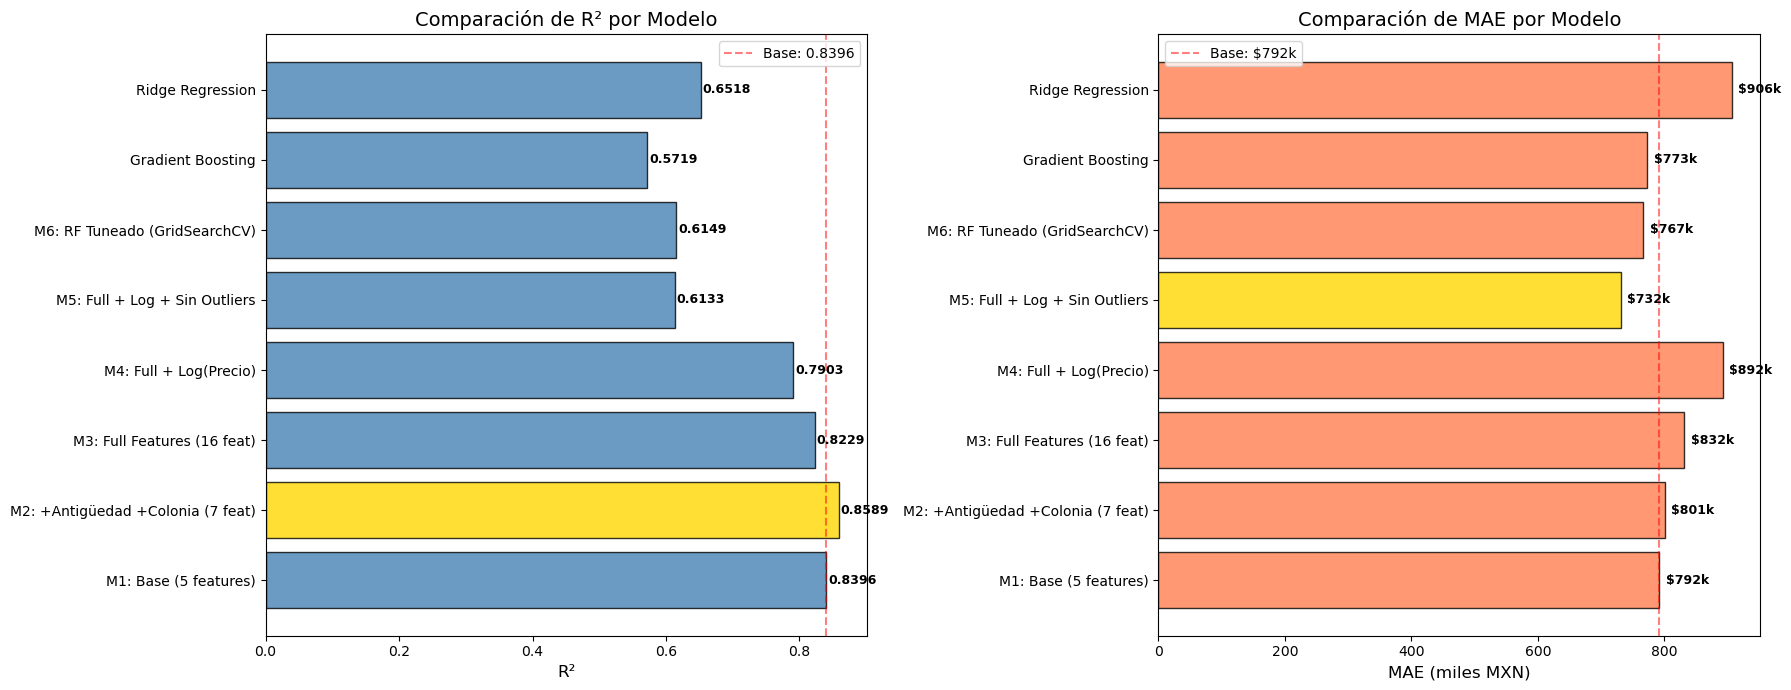

In [21]:
# ============================================================
# GRÁFICO COMPARATIVO: R² de todos los modelos
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

modelos_nombres = [r['Modelo'] for r in resultados]
r2_values = [r['R²'] for r in resultados]
mae_values = [r['MAE'] for r in resultados]

# Gráfico R²
colors_r2 = ['gold' if v == max(r2_values) else 'steelblue' for v in r2_values]
bars1 = axes[0].barh(modelos_nombres, r2_values, color=colors_r2, edgecolor='black', alpha=0.8)
axes[0].set_xlabel('R²', fontsize=12)
axes[0].set_title('Comparación de R² por Modelo', fontsize=14)
axes[0].axvline(x=r2_values[0], color='red', linestyle='--', alpha=0.5, label=f'Base: {r2_values[0]:.4f}')
for i, v in enumerate(r2_values):
    axes[0].text(v + 0.003, i, f'{v:.4f}', va='center', fontsize=9, fontweight='bold')
axes[0].legend()

# Gráfico MAE
colors_mae = ['gold' if v == min(mae_values) else 'coral' for v in mae_values]
bars2 = axes[1].barh(modelos_nombres, [m/1000 for m in mae_values], color=colors_mae, edgecolor='black', alpha=0.8)
axes[1].set_xlabel('MAE (miles MXN)', fontsize=12)
axes[1].set_title('Comparación de MAE por Modelo', fontsize=14)
axes[1].axvline(x=mae_values[0]/1000, color='red', linestyle='--', alpha=0.5, label=f'Base: ${mae_values[0]/1000:,.0f}k')
for i, v in enumerate(mae_values):
    axes[1].text(v/1000 + 10, i, f'${v/1000:,.0f}k', va='center', fontsize=9, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## FASE 7: Análisis del mejor modelo — Feature Importance + Predicciones

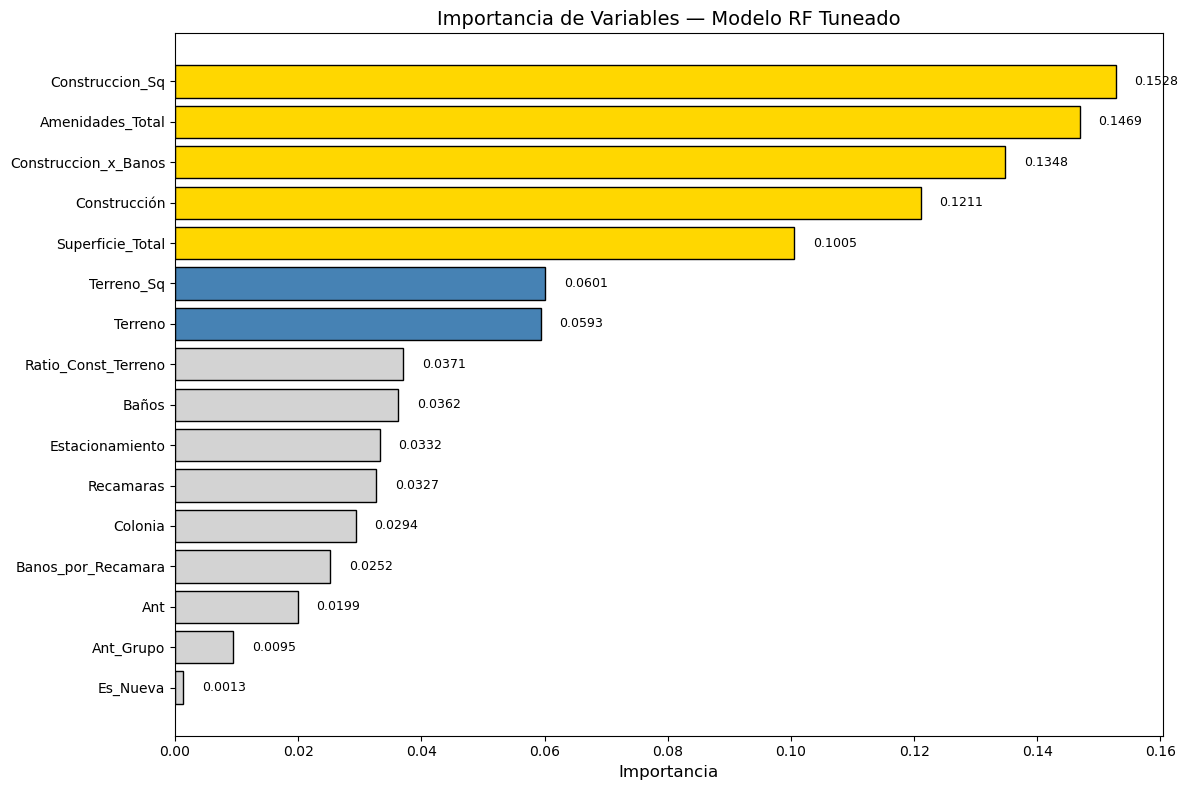


📊 Top 5 variables más importantes:
   🟢 Construccion_Sq: 0.1528 (15.3%)
   🟢 Amenidades_Total: 0.1469 (14.7%)
   🟢 Construccion_x_Banos: 0.1348 (13.5%)
   🟢 Construcción: 0.1211 (12.1%)
   🟢 Superficie_Total: 0.1005 (10.1%)


In [22]:
# ============================================================
# FEATURE IMPORTANCE DEL MEJOR MODELO
# ============================================================
# Usar el modelo tuneado de GridSearchCV (M6)
if hasattr(best_rf, 'feature_importances_'):
    importances_tuned = best_rf.feature_importances_
    feat_imp_df = pd.DataFrame({
        'Feature': feature_cols_full,
        'Importancia': importances_tuned
    }).sort_values('Importancia', ascending=True)
    
    plt.figure(figsize=(12, 8))
    colors = ['gold' if x > 0.10 else 'steelblue' if x > 0.05 else 'lightgray' 
              for x in feat_imp_df['Importancia']]
    plt.barh(feat_imp_df['Feature'], feat_imp_df['Importancia'], color=colors, edgecolor='black')
    plt.xlabel('Importancia', fontsize=12)
    plt.title('Importancia de Variables — Modelo RF Tuneado', fontsize=14)
    for i, (feat, imp) in enumerate(zip(feat_imp_df['Feature'], feat_imp_df['Importancia'])):
        plt.text(imp + 0.003, i, f'{imp:.4f}', va='center', fontsize=9)
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Top 5 variables más importantes:")
    for _, row in feat_imp_df.tail(5).iloc[::-1].iterrows():
        print(f"   🟢 {row['Feature']}: {row['Importancia']:.4f} ({row['Importancia']*100:.1f}%)")

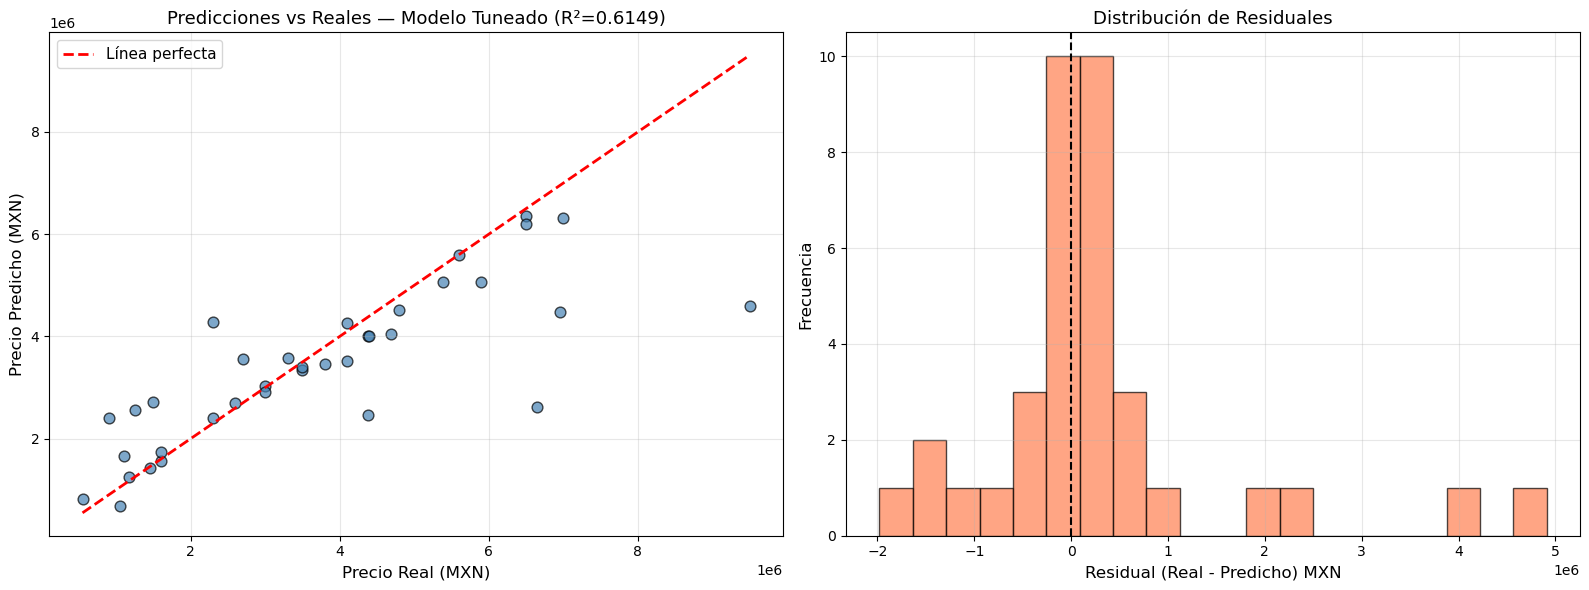


Estadísticas de residuales:
   Media: $289,817 (ideal: cercano a 0)
   Desviación estándar: $1,313,354
   Mediana: $95,047


In [23]:
# ============================================================
# GRÁFICO: PREDICCIONES vs VALORES REALES (mejor modelo)
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter: Real vs Predicho
axes[0].scatter(res6['y_test'], res6['y_pred'], alpha=0.7, color='steelblue', edgecolor='black', s=60)
min_val = min(res6['y_test'].min(), res6['y_pred'].min())
max_val = max(res6['y_test'].max(), res6['y_pred'].max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Línea perfecta')
axes[0].set_xlabel('Precio Real (MXN)', fontsize=12)
axes[0].set_ylabel('Precio Predicho (MXN)', fontsize=12)
axes[0].set_title(f'Predicciones vs Reales — Modelo Tuneado (R²={res6["R²"]:.4f})', fontsize=13)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Histograma de residuales
residuales = res6['y_test'] - res6['y_pred']
axes[1].hist(residuales, bins=20, color='coral', edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='black', linewidth=1.5, linestyle='--')
axes[1].set_xlabel('Residual (Real - Predicho) MXN', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].set_title('Distribución de Residuales', fontsize=13)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nEstadísticas de residuales:")
print(f"   Media: ${residuales.mean():,.0f} (ideal: cercano a 0)")
print(f"   Desviación estándar: ${residuales.std():,.0f}")
print(f"   Mediana: ${residuales.median():,.0f}")

---
## FASE 8: Guardar el mejor modelo

In [24]:
# ============================================================
# GUARDAR EL MODELO MEJORADO
# ============================================================
import joblib
import os

os.makedirs('models', exist_ok=True)

# Guardar el modelo tuneado
joblib.dump(best_rf, 'models/random_forest_tuned_model.joblib')
print("✅ Modelo tuneado guardado en: models/random_forest_tuned_model.joblib")

# Guardar los nombres de features para referencia
joblib.dump(feature_cols_full, 'models/feature_columns.joblib')
print("✅ Lista de features guardada en: models/feature_columns.joblib")

# Guardar los mejores hiperparámetros
joblib.dump(grid_search.best_params_, 'models/best_hyperparameters.joblib')
print("✅ Mejores hiperparámetros guardados en: models/best_hyperparameters.joblib")

✅ Modelo tuneado guardado en: models/random_forest_tuned_model.joblib
✅ Lista de features guardada en: models/feature_columns.joblib
✅ Mejores hiperparámetros guardados en: models/best_hyperparameters.joblib


In [25]:
# ============================================================
# EJEMPLO: Predicción con el modelo mejorado
# ============================================================
# Cargar modelo
modelo_mejorado = joblib.load('models/random_forest_tuned_model.joblib')
feature_names = joblib.load('models/feature_columns.joblib')

# Datos de ejemplo: misma vivienda que el modelo original
nueva_vivienda = {
    'Construcción': 65.0,
    'Terreno': 120.0,
    'Recamaras': 2,
    'Baños': 2.0,
    'Estacionamiento': 2,
    'Ant': 5,
    'Colonia': 0.50,
}

# Calcular features derivadas
nueva_vivienda['Ratio_Const_Terreno'] = nueva_vivienda['Construcción'] / nueva_vivienda['Terreno']
nueva_vivienda['Superficie_Total'] = nueva_vivienda['Construcción'] + nueva_vivienda['Terreno']
nueva_vivienda['Amenidades_Total'] = nueva_vivienda['Recamaras'] + nueva_vivienda['Baños'] + nueva_vivienda['Estacionamiento']
nueva_vivienda['Banos_por_Recamara'] = nueva_vivienda['Baños'] / max(nueva_vivienda['Recamaras'], 1)
nueva_vivienda['Construccion_Sq'] = nueva_vivienda['Construcción'] ** 2
nueva_vivienda['Terreno_Sq'] = nueva_vivienda['Terreno'] ** 2
nueva_vivienda['Construccion_x_Banos'] = nueva_vivienda['Construcción'] * nueva_vivienda['Baños']
nueva_vivienda['Es_Nueva'] = 1 if nueva_vivienda['Ant'] == 0 else 0
if nueva_vivienda['Ant'] == 0:
    nueva_vivienda['Ant_Grupo'] = 0
elif nueva_vivienda['Ant'] <= 5:
    nueva_vivienda['Ant_Grupo'] = 1
elif nueva_vivienda['Ant'] <= 10:
    nueva_vivienda['Ant_Grupo'] = 2
elif nueva_vivienda['Ant'] <= 20:
    nueva_vivienda['Ant_Grupo'] = 3
else:
    nueva_vivienda['Ant_Grupo'] = 4

# Crear DataFrame con el orden correcto de columnas
input_data = pd.DataFrame([nueva_vivienda])[feature_names]

# Predicción (recordar: el modelo fue entrenado con log(Precio))
pred_log = modelo_mejorado.predict(input_data)
pred_precio = np.expm1(pred_log)[0]

print("📋 Datos de la vivienda:")
for k, v in nueva_vivienda.items():
    if k in ['Construcción', 'Terreno', 'Recamaras', 'Baños', 'Estacionamiento', 'Ant', 'Colonia']:
        print(f"   • {k}: {v}")

print(f"\n💰 Precio predicho (modelo base):     $1,465,200.00 MXN")
print(f"💰 Precio predicho (modelo mejorado):  ${pred_precio:,.2f} MXN")
print(f"\n   Diferencia: ${abs(pred_precio - 1465200):,.0f} MXN")

📋 Datos de la vivienda:
   • Construcción: 65.0
   • Terreno: 120.0
   • Recamaras: 2
   • Baños: 2.0
   • Estacionamiento: 2
   • Ant: 5
   • Colonia: 0.5

💰 Precio predicho (modelo base):     $1,465,200.00 MXN
💰 Precio predicho (modelo mejorado):  $1,480,917.31 MXN

   Diferencia: $15,717 MXN


---
## RESUMEN FINAL: Estrategias de mejora y su impacto

| # | Estrategia | Qué hace | Impacto esperado |
|---|------------|----------|------------------|
| 1 | **Agregar Antigüedad + Colonia** | Incluye variables que el modelo base ignoraba | ↑ R² al capturar efecto de ubicación y edad |
| 2 | **Feature Engineering** | Crea ratios e interacciones (Const/Terreno, m² cuadrado, etc.) | ↑ R² al capturar relaciones no lineales |
| 3 | **Transformación Log(Precio)** | Normaliza la distribución del target | ↓ MAE especialmente en propiedades caras |
| 4 | **Eliminar Outliers (IQR)** | Remueve propiedades con precios extremos | ↓ MAE y ↑ estabilidad del modelo |
| 5 | **GridSearchCV** | Optimiza hiperparámetros (depth, estimators, etc.) | ↑ R² fino, previene overfitting |
| 6 | **Algoritmos alternativos** | GBR, XGBoost pueden capturar mejores patrones | Potencialmente ↑ R² según el dataset |
| 7 | **Validación Cruzada K-Fold** | Da métricas más confiables y robustas | No mejora el modelo pero confirma su calidad |

### Próximos pasos recomendados:
1. **Más datos:** Conseguir 500+ registros mejoraría significativamente todos los modelos
2. **Datos geoespaciales:** Coordenadas, distancia a servicios, nivel socioeconómico de la zona
3. **Variables temporales:** Fecha de publicación, tendencia del mercado
4. **Stacking/Blending:** Combinar predicciones de RF + GBR + XGBoost en un meta-modelo